In [1]:
import os
os.chdir(os.environ["USERPROFILE"]+"/Desktop/Jupyter-GPU/data/nasa_planet_gan/")

In [2]:
from IPython import display as ipydisplay
from PIL import Image
from importlib import reload
import pickle
import time
import random
import tensorflow as tf
import numpy as np
#import keras as keras
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import loadfunctions as lf
import tf_gan as tfg

In [3]:
input_width = 128
input_height = int(input_width*.75)
input_channels = 3
num_examples_to_generate = 16
noise_dim = 64
BATCH_SIZE = 128

In [4]:
reload(lf)
reload(tfg)

<module 'tf_gan' from 'C:\\Users\\Tasha\\Desktop\\Jupyter-GPU\\data\\nasa_planet_gan\\tf_gan.py'>

In [5]:
batch = tfg.create_batch(input_height,input_width, 40)
#print(batch.shape)
#grid = tfg.create_image_grid(batch,16)
#tfg.get_image(grid).show()
#for i in range(0,180,10):    
#    ex1 = batch[0]
#    ex1 = lf._rotate_and_crop(ex1,input_height,input_width,i)
#    try:
#        ex1=ex1.numpy()
#    except:
#        pass
#    tfg.get_image(ex1).show()
#

#ex2 = lf._rotate_and_crop(ex1.numpy().copy(),input_height,input_width,35)
#get_image(ex2.numpy()).show()

#get_image(batch[-1]).show()
#get_image(batch[-2]).show()

#tf.image.resize
#batch = create_batch(2,2)
#tfg.get_image(batch[-0]).show()
#tfg.get_image(batch[-1]).show()
#tfg.get_image(batch[-2]).show()

In [6]:
ipydisplay.display(
tf.keras.preprocessing.image.array_to_img(batch[
    random.randint(0,len(batch))]))

In [7]:
X_train= batch

np.random.shuffle(X_train)
ipydisplay.display(tf.keras.preprocessing.image.array_to_img(X_train[0]))

test_num = int(len(X_train)*.1)
X = X_train[0:-test_num]
X_test = X_train[-test_num:]

print(f"X_train: {X.shape}, X_test: {X_test.shape}")

In [8]:
# function to provide the generator of the GAN
from tensorflow.keras.layers import BatchNormalization,Dense,Activation

def generator_model(output_width,
                    output_height,
                    output_channels,
                    latent_dim,
                    filters_list=[512,256,64,32,16,8,4,2],
                    dtype=tf.float32):
    w8 = int(output_width/8)
    h8 = int(output_height/8)
    con_t_layers=filters_list
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(latent_dim)))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192),dtype=dtype ))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192) ,dtype=dtype))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192),dtype=dtype))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Reshape(target_shape=(h8,w8,-1)))
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[0],kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[1],kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.Activation('tanh',dtype=dtype))
    #model.add(tf.keras.layers.Add(1.0))

    return model

In [9]:
# function to provide the discriminator of the GAN
def discriminator_model(dropout =.1, filters_list = [2**7,2**8,2**9]):
    drop_out_list = [dropout,
                     dropout,
                     dropout]
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[0]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[2],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[2]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

def discriminator_model_dense_working(dropout =.1):
    drop_out_list = [.5,.4,.33]
    filters_list = [64]
    model = tf.keras.Sequential()    
    model.add(tf.keras.layers.BatchNormalization(input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=8))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=4))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=2))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

# function to provide the discriminator of the GAN
def discriminator_model(dropout =.1, filters_list = [2**7,2**8,2**9]):
    drop_out_list = [.5,.4,.33]
    filters_list = [8,16,32]
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape=(input_height,input_width,input_channels)))    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('selu'))
    
    model.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5),strides=(1,1),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('selu'))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(units=200))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('selu'))
             
    model.add(tf.keras.layers.Dense(units=200))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('selu'))
    
    model.add(tf.keras.layers.Dense(units=200))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('selu'))

    
    #for i in [512,512,256,256,128,128,64,64,32,32,16,16,8,8,4,4,2,2]:
    #for i in [512,512,128,128,64,64,16,16,4,4,2,2]:
    for i in list(range(202,2,-20)):
        model.add(tf.keras.layers.Dense(units=i))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('selu'))

    
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss,real_loss,fake_loss

In [12]:
def generator_loss(fake_output):
    # generator wants to fool the discriminator
    # so we must define a loss function for the generator

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
# selective discriminator on 5,6,7,8,9
# no selective discriminator on 1,2,3,4,

# tanh on 6,7,8,9

scale = 4 # 1,2
scale = 20 #4,5,6
scale = 15 #7
scale = 10 #3,8,9
scale = 4 #X

disc_dropout_scale =  1 # 1,2,3,4,5,6,7,8,
disc_dropout_scale = .5 # 9
disc_dropout_scale = .1 # X

orig_gen = 4e-5
orig_dis = 5e-7

mod_gen = 4e-5+4e-5 #1,2,3,4,5,6,7,8,9
mod_dis = 5e-7+0    #1,2,3,4,5,6,7,8,9
mod_dis = .9e-7+0    #X

ratio = (4e-5/.5e-6)
ratio = ((orig_gen)/
         (orig_dis))

gen_lr = mod_gen*scale
disc_lr = mod_dis*scale

In [14]:
generator = generator_model(output_width=input_width,
                            output_height=input_height,
                            output_channels=input_channels,
                            latent_dim= 512)
print(generator.summary())

In [15]:
discriminator = discriminator_model(dropout=disc_dropout_scale)
print(discriminator.summary())

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.000002,beta_1=.5)
#discriminator.compile(loss='binary_crossentropy',optimizer=discriminator_optimizer,metrics=['accuracy'])

In [16]:

# a= b/c
# b= ac
# c=b/a
print(gen_lr,disc_lr,ratio,gen_lr/disc_lr)
generator_optimizer     = tf.keras.optimizers.Adam(gen_lr)

In [17]:

discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)

In [18]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#run_exp.noise = tf.random.normal([use_batch_size, exp.latent_dim])   

In [19]:
def maintain_history(_results_history,_results):
    if len(_results_history)==1:
        #_results_history = dict(_results)
        for key in _results:
            if key != 'epoch':
                _results_history[key] = []
    else:
        # append results to results_history
        for key in _results_history:
            if 'epoch' not in key:
                _results_history[key].append(_results[key])


    return _results_history

In [20]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1


        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if (epoch % 10 == 0) or (epoch == 1):
            tfg.display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            tfg.display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        tfg.save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [21]:
def prepare_series_for_graph(np_arr,smooth = True,clip =True):
    # print performance for this function
    s_time = time.time()
    out = np.array(np_arr)

    # smooth the results_history
    if smooth:
        out  = np.convolve(out, np.ones((10,))/10, mode='valid')
    # clip the results_history
    if clip:
        c=np.percentile(out, 95)
        out = out[out < c]
    e_time = time.time()
    #print(f"Time for smooth: {smooth} and clip: {clip} was {e_time - s_time}")

    return out.astype(np.float16)

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator,discriminator,
               images,               
               selective_discriminator_training,               
               hist,
               d_grad_scale_accum,
               g_grad_scale_accum,
               grad_scale_power,
               use_grad_scale:bool):
    noise = tf.random.normal((len(images),
                              generator.layers[0].input.shape[1]
                             ))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate noise to feed to the generator and get generated images.
        generated_images = generator(noise, training = generator.trainable)
        # call the discriminator with the real images and get its guesses
        real_output = discriminator(images, training = discriminator.trainable )
        # call the discriminator with the generated images and get the output
        fake_output = discriminator(generated_images, training = discriminator.trainable)
        gen_loss = generator_loss(fake_output)
        disc_loss,real_loss,fake_loss = discriminator_loss(real_output, fake_output)

    # track the number of fake images that fooled the discriminator where >.5
    fooled_per = tf.divide(tf.math.count_nonzero(fake_output > .5),BATCH_SIZE,"fooled_percent_calc")
    fooled = tf.math.count_nonzero(fake_output > .5)

    # Calculate the gradients for generator and discriminator.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)    
    report_d_grad_scale=1.0
    report_g_grad_scale=1.0
    equilibrium_scale=1.0
    #equilibrium_scale =tf.Variable(0,dtype=tf.float32)
    if use_grad_scale:
        #### Gen
        g_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        g_grad_scale = g_grad_scale * -2
        # range is -1 to +1, +1 when 100% of samples in batch DO NOT fool the discriminator
        g_grad_scale = g_grad_scale * grad_scale_power
        
        
        
        #### Disc
        d_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        d_grad_scale = d_grad_scale * 2
        # range is -1 to +1, +1 when 100% of samples in batch fool the discriminator
        d_grad_scale = d_grad_scale * grad_scale_power
        
        
        #equilibrium_scale=tf.cast((-((5*fooled_per)-2.5)**2+4)/6, dtype=tf.float32)*grad_scale_power
        equilibrium_scale=tf.cast((-((5.0*fooled_per)-2.0)**2.0+4.0)/4.0, dtype=tf.float32)*grad_scale_power
        #equilibrium_scale =(0.1(1/((fooled_per*4)−2)))**2
        
        d_grad_scale_accum.assign_add(d_grad_scale+equilibrium_scale)
        d_grad_scale_accum = tf.maximum(d_grad_scale_accum,-0.99)       
        d_grad_scale_tot = tf.constant(1.0, dtype=tf.float32) + d_grad_scale_accum
        

        g_grad_scale_accum.assign_add(g_grad_scale+equilibrium_scale)        
        g_grad_scale_accum = tf.maximum(g_grad_scale_accum,-0.99)
        g_grad_scale_tot = tf.cast(
            tf.add(tf.constant(1.0, dtype=tf.float32),g_grad_scale_accum),
            tf.float32)
        
        gradients_of_generator= [tf.math.scalar_mul(g_grad_scale_tot, grad) for grad in gradients_of_generator]
        gradients_of_discriminator= [tf.math.scalar_mul(d_grad_scale_tot,grad) for grad in gradients_of_discriminator]
                
        report_d_grad_scale=d_grad_scale_accum
        report_g_grad_scale=g_grad_scale_accum    
       
        
        
    # Apply gradients to the optimizer.
    generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    if selective_discriminator_training:
        if gen_loss < 1:
            #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return a dictionary of disc_loss, real_loss, fake_loss, gen_loss,fooled
    disc_lr = tf.keras.backend.get_value(discriminator.optimizer.learning_rate)
    gen_lr = tf.keras.backend.get_value(generator.optimizer.learning_rate)
    return {'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power}

In [23]:

d_grad_scale_accum = tf.Variable(0.0)
g_grad_scale_accum = tf.Variable(0.0)

In [24]:
from dataclasses import dataclass
@dataclass
class experiment:
    name:str
    generator:None
    discriminator:None
    generator_src=None
    discriminator_src=None
    batch_size:int = 64
    train_shape:()=(0,0)
    example_noise = None
    g_lr:float=1e-6
    d_lr:float=1e-6
    start_gen_gsa:float=0.0
    start_disc_gsa:float=0.0
    grad_power:float=.01    
    epochs:int = 2000
    results_history=None
    use_grad_scale:bool=True
    latent_dim:int =100
    dropout:float=0.0
    disc_filters_list:list=None
    gen_filters_list:list=None
    
    

In [25]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

In [26]:
for i in exp3.results_history:
    print(i)
plt.plot(exp3.results_history["gen_lr"])
plt.plot(exp3.results_history["disc_lr"])
plt.show()
print(exp3.results_history["disc_lr"][-1])
print(exp3.results_history["gen_lr"][-1])

exp3a = experiment("exp3a - restart of prematurly ended exp3",
                  g_lr=1e-6,
                  d_lr=1e-6,
                  start_gen_gsa=-0.9288066,
                  start_disc_gsa=159.65173,
                  grad_power=0.05,
                  batch_size=64,                  
                  epochs=2000)
exp3a.results_history=exp3.results_history
print(exp3a)
run_exp(exp3a)

In [27]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(10)
            
             
def run_exp(exp:experiment):
    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)

    lf.save_np_image_list(X_train,"augs")   
    
    if exp.discriminator is None:
        print("new discriminator")
        exp.discriminator = discriminator_model(dropout=exp.dropout,filters_list=exp.disc_filters_list)
        print("new discriminator optimizer")
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    if exp.results_history == None:
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
    
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim,dtype=tf.float32,
                                        filters_list = exp.gen_filters_list
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:
        start=exp.results_history["epoch"]
        epochs=100
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)        
        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) <= exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            #print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=-1
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
        
        
        print("Batch size: ",use_batch_size,"of: ", exp.batch_size)
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time    
    with open("exp.data","w+") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    plt.figure(figsize = (100,12))
    for k,v in exp.results_history.items():
        if( v.__class__ == list) and(k!="fooled"):
            print(k)
            skip = int(len(v)/14000.0)
            skip = min(skip,10)
            skip = max(1,skip)
            
            plt.plot(v[::skip])
    plt.savefig("plt.jpg")

    save_models(generator,discriminator)
    

In [28]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

In [29]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1


        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if "np_img" not in dir(tfg.display):
        tfg.display.np_img = np.zeros(
            (
                input_height*2,
                input_width*8,
                input_channels
            )
            )
        if (epoch % 10 == 0) or (epoch == 1):
            
            tfg.display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            tfg.display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        tfg.save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [30]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1


        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if "np_img" not in dir(tfg.display):
            tfg.display.np_img = np.zeros(
                (
                    input_height*2,
                    input_width*8,
                    input_channels
                )
                )
        if (epoch % 10 == 0) or (epoch == 1):
            
            tfg.display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            tfg.display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        tfg.save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [31]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

In [32]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

In [33]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

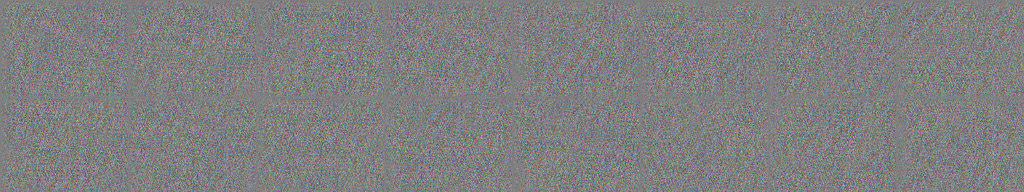

In [34]:
import os
reload(lf)
reload(tfg)
import wandb
def wnb():
    with wandb.init() as run:
        config = wandb.config
        ex= experiment(f'wnb',
                  generator=None,
                  discriminator=None,
                  g_lr = config["g_lr"],
                  d_lr = config["d_lr"],
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.000001,
                  batch_size=[config["batch_size"]],
                  epochs=100,
                  latent_dim = 300,
                  dropout=0.0,
                  use_grad_scale= False,
                  disc_filters_list = None,
                  gen_filters_list = [64+32,32+16] 
                  )
        print (config)
        run_exp(ex)


count = 5 # number of runs to execute
wandb.agent("ymtfpo8o", function=wnb, count=1)

#print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)